# GBM - Multiple Targets
- Data Split 
    - Apply 80/20 split by Ticker
    - For calculating performance, use 5 fold cross validation targetting RMSE
- Build GBM by Ticker
- Make prediction for close at T+1 - T+5

In [359]:
import os, sys
import xgboost
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..', 'src')))
# Load tabulation creation function from analysis tools repo
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '../..', 'analysis_tools/src')))
from create_tabulation import  generate_and_save_tabulations

In [360]:
TICKER = "AAPL"
ACTUAL_PREFIX = "return"
RESPONSE_VARS = [f"return_t+{day}" for day in range(1, 6)]
pred_prefix = f"pred_{ACTUAL_PREFIX}_t+"


# Predict 2 weeks into the future
FUTURE_DAYS_TO_TEST = 25

In [361]:
ACTUAL_PREFIX, pred_prefix

('return', 'pred_return_t+')

In [362]:
df = pd.read_parquet("../data/processed/20250518/daily_with_finbert_and_indicators.parquet")

In [363]:
df["return"] = df["return_t+1"].shift(1)
df[["return", "return_t+1"]].head()

,return,return_t+1
0,NaN,-0.028797
1,-0.028797,-0.010399
2,-0.010399,-0.038048
3,-0.038048,-0.042193
4,-0.042193,0.076868


In [364]:
df["ticker"].unique()

array(['AAPL', 'AMZN', 'HD', 'JPM', 'KO', 'MSFT', 'NVDA', 'TSLA', 'UNH',
       'XOM'], dtype=object)

In [365]:
df = df.query(f"ticker == '{TICKER}'").reset_index(drop=True)

In [366]:
df.shape

(3784, 806)

In [367]:
df.head()

,ticker,date,open,high,low,close,volume,return_t+1,headlines,finbert_0,...,close_smoothed_alpha:0.25,close_smoothed_alpha:0.75,close_smoothed_alpha:0.9,return_t+1_smoothed_alpha:0.25,return_smoothed_alpha:0.25,return_t+1_smoothed_alpha:0.75,return_smoothed_alpha:0.75,return_t+1_smoothed_alpha:0.9,return_smoothed_alpha:0.9,return
0,AAPL,2010-05-03,9.422857,9.567143,9.388571,9.512500,4.543420e+08,-0.028797,[],0.0,...,9.512500,9.512500,9.512500,-0.028797,NaN,-0.028797,NaN,-0.028797,NaN,NaN
1,AAPL,2010-05-04,9.388929,9.403214,9.169643,9.238571,7.238196e+08,-0.010399,[],0.0,...,9.444018,9.307053,9.265964,-0.024197,-0.028797,-0.014998,-0.028797,-0.012239,-0.028797,-0.028797
2,AAPL,2010-05-05,9.036786,9.219286,8.883214,9.142500,8.831032e+08,-0.038048,[],0.0,...,9.368638,9.183638,9.154846,-0.027660,-0.024197,-0.032286,-0.014998,-0.035467,-0.012239,-0.010399
3,AAPL,2010-05-06,9.065357,9.223214,7.116071,8.794643,1.285861e+09,-0.042193,[],0.0,...,9.225140,8.891892,8.830664,-0.031293,-0.027660,-0.039716,-0.032286,-0.041520,-0.035467,-0.038048
4,AAPL,2010-05-07,8.703929,8.806071,8.043214,8.423571,1.676018e+09,0.076868,[],0.0,...,9.024747,8.540651,8.464280,-0.004253,-0.031293,0.047722,-0.039716,0.065029,-0.041520,-0.042193


In [368]:
df.tail()

,ticker,date,open,high,low,close,volume,return_t+1,headlines,finbert_0,...,close_smoothed_alpha:0.25,close_smoothed_alpha:0.75,close_smoothed_alpha:0.9,return_t+1_smoothed_alpha:0.25,return_smoothed_alpha:0.25,return_t+1_smoothed_alpha:0.75,return_smoothed_alpha:0.75,return_t+1_smoothed_alpha:0.9,return_smoothed_alpha:0.9,return
3779,AAPL,2025-05-09,199.000000,200.539993,197.539993,198.529999,36453900.0,0.061754,[Apple Building Specialized Chips for Smart Gl...,-0.06001,...,200.375572,198.237476,198.415970,0.013299,-0.002853,0.047430,0.004460,0.056099,0.005201,0.005266
3780,AAPL,2025-05-12,210.970001,211.270004,206.750000,210.789993,63775800.0,0.010152,[],0.00000,...,202.979177,207.651864,209.552591,0.012512,0.013299,0.019472,0.047430,0.014747,0.056099,0.061754
3781,AAPL,2025-05-13,210.429993,213.399994,209.000000,212.929993,51909300.0,-0.002818,[],0.00000,...,205.466881,211.610461,212.592253,0.008680,0.012512,0.002755,0.019472,-0.001061,0.014747,0.010152
3782,AAPL,2025-05-14,212.429993,213.940002,210.580002,212.330002,49325800.0,-0.004145,[],0.00000,...,207.182661,212.150117,212.356227,0.005474,0.008680,-0.002420,0.002755,-0.003836,-0.001061,-0.002818
3783,AAPL,2025-05-15,210.949997,212.960007,209.539993,211.449997,45029500.0,-0.000899,[],0.00000,...,208.249495,211.625027,211.540620,0.003881,0.005474,-0.001279,-0.002420,-0.001192,-0.003836,-0.004145


<Axes: >

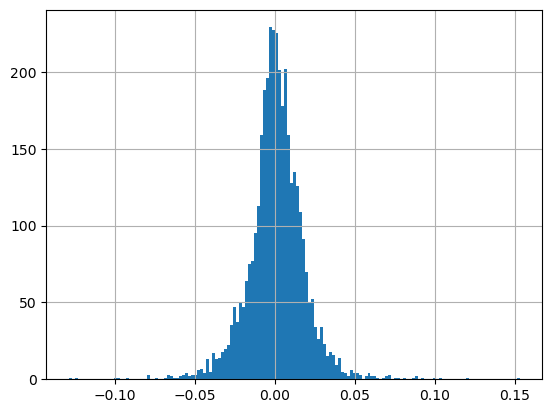

In [369]:
df[ACTUAL_PREFIX].hist(bins=int(df.shape[0] / 25))

## Add Target @ T+1 through T+5 as variables to test modeling
- Observe performance when predicting days in advance
- How to build a strategy with this approach?

In [370]:
for lag in range(1, 6):
    df[f"{ACTUAL_PREFIX}_t+{lag}"] = df[ACTUAL_PREFIX].shift(-lag)

In [371]:
df[[ACTUAL_PREFIX, *[f"{ACTUAL_PREFIX}_t+{day}" for day in range(1, 6)]]].head(10)

,return,return_t+1,return_t+2,return_t+3,return_t+4,return_t+5
0,NaN,-0.028797,-0.010399,-0.038048,-0.042193,0.076868
1,-0.028797,-0.010399,-0.038048,-0.042193,0.076868,0.009961
2,-0.010399,-0.038048,-0.042193,0.076868,0.009961,0.021714
3,-0.038048,-0.042193,0.076868,0.009961,0.021714,-0.014232
4,-0.042193,0.076868,0.009961,0.021714,-0.014232,-0.017572
5,0.076868,0.009961,0.021714,-0.014232,-0.017572,0.001576
6,0.009961,0.021714,-0.014232,-0.017572,0.001576,-0.007316
7,0.021714,-0.014232,-0.017572,0.001576,-0.007316,-0.015930
8,-0.014232,-0.017572,0.001576,-0.007316,-0.015930,-0.042603
9,-0.017572,0.001576,-0.007316,-0.015930,-0.042603,0.019179


In [372]:
df[[ACTUAL_PREFIX, *[f"{ACTUAL_PREFIX}_t+{day}" for day in range(1, 6)]]].tail(10)

,return,return_t+1,return_t+2,return_t+3,return_t+4,return_t+5
3774,-0.037362,-0.031459,-0.001911,-0.011385,0.006318,0.005266
3775,-0.031459,-0.001911,-0.011385,0.006318,0.005266,0.061754
3776,-0.001911,-0.011385,0.006318,0.005266,0.061754,0.010152
3777,-0.011385,0.006318,0.005266,0.061754,0.010152,-0.002818
3778,0.006318,0.005266,0.061754,0.010152,-0.002818,-0.004145
3779,0.005266,0.061754,0.010152,-0.002818,-0.004145,NaN
3780,0.061754,0.010152,-0.002818,-0.004145,NaN,NaN
3781,0.010152,-0.002818,-0.004145,NaN,NaN,NaN
3782,-0.002818,-0.004145,NaN,NaN,NaN,NaN
3783,-0.004145,NaN,NaN,NaN,NaN,NaN


In [373]:
df.dropna(subset=RESPONSE_VARS, inplace=True)

### Apply data split
- For initial test, build model on 90% and validate on 10% OOT
    - Tune hyperparameters using CV on Train set

- For future, always validate on most recent months and add additional data to holdout set

In [374]:
df = df.query(f"ticker == '{TICKER}'").reset_index(drop=True)

In [375]:
df = df.sort_values("date")

In [376]:
TEST_START_INDEX = df.shape[0] - FUTURE_DAYS_TO_TEST

train = df.loc[df.index < TEST_START_INDEX, :]
test = df.loc[df.index >= TEST_START_INDEX, :]

train.shape, test.shape

((3754, 810), (25, 810))

In [377]:
df.shape

(3779, 810)

### Build initial models on each `close` variables
- Use ARIMA as a baseline (and potentially use as a feature)

In [378]:
keys = ["ticker", "date"]
non_modeling_vars = ["headlines", *[col for col in df.columns if "_t+" in col]]
print(non_modeling_vars)

['headlines', 'return_t+1', 'return_t+1_smoothed_alpha:0.25', 'return_t+1_smoothed_alpha:0.75', 'return_t+1_smoothed_alpha:0.9', 'return_t+2', 'return_t+3', 'return_t+4', 'return_t+5']


In [ ]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error
import xgboost as xgb
import numpy as np

# Store results
results = {}
feature_importances_lists = {}
best_rounds = {}

# Specify predictors
X = train.drop(columns=keys + non_modeling_vars)

for target in RESPONSE_VARS:

    # Store results for each target in a dictionary
    results[target] = []
    feature_importances_lists[target] = []
    best_rounds[target] = []

    # Prepare the target
    y = train[target]

    # XGBoost parameters
    params = {
        'objective': 'reg:squarederror',
        'eval_metric': 'rmse',
        'max_depth': 5,
        'learning_rate': 0.1
    }

    # TimeSeriesSplit for sequential cross-validation
    tscv = TimeSeriesSplit(n_splits=3)

    for fold, (train_index, test_index) in enumerate(tscv.split(X)):
        print(f"\n=== Fold {fold + 1} ===")

        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        dtrain = xgb.DMatrix(X_train, label=y_train)
        dvalid = xgb.DMatrix(X_test, label=y_test)

        # Train model with early stopping using validation fold
        model = xgb.train(
            params=params,
            dtrain=dtrain,
            num_boost_round=250,
            evals=[(dvalid, "eval")],
            early_stopping_rounds=10,
            verbose_eval=25
        )

        best_rounds[target].append(model.best_iteration)

        # Predict on test set
        y_pred = model.predict(dvalid)
        rmse = mean_squared_error(y_test, y_pred, squared=False)
        print(f"Fold RMSE: {rmse:.4f}")
        results[target].append(rmse)

        # Get and sort feature importances
        feature_importances = model.get_score(importance_type='weight')
        sorted_importances = sorted(feature_importances.items(), key=lambda x: x[1], reverse=True)
        feature_importances_lists[target].append(dict(sorted_importances))

    # Final results
    average_rmse = np.mean(results[target])
    print(f"\nAverage RMSE across all folds for {target}: {average_rmse:.4f}")




=== Fold 1 ===
[0]	eval-rmse:0.44952
[25]	eval-rmse:0.03581
[50]	eval-rmse:0.01576
[54]	eval-rmse:0.01625
Fold RMSE: 0.0163

=== Fold 2 ===
[0]	eval-rmse:0.44901
[25]	eval-rmse:0.03833
[50]	eval-rmse:0.02178
[61]	eval-rmse:0.02190
Fold RMSE: 0.0219

=== Fold 3 ===
[0]	eval-rmse:0.44995


In [ ]:
# === Final Feature Selection Across Targets ===
top_n = 25  # Number of top features to consider
intersections_by_target = {}

# Step 1: Intersect across folds for each target
for target in RESPONSE_VARS:
    top_features_per_fold = [
        list(feats.keys())[:top_n]
        for feats in feature_importances_lists[target]
    ]
    # Intersect across 3 folds
    intersection = set(top_features_per_fold[0])
    for feature_list in top_features_per_fold[1:]:
        intersection = intersection.intersection(feature_list)
    intersections_by_target[target] = intersection
    print(f"{target}: {len(intersection)} features in fold intersection")

return_t+1: 23 features in fold intersection
return_t+2: 22 features in fold intersection
return_t+3: 24 features in fold intersection
return_t+4: 23 features in fold intersection
return_t+5: 25 features in fold intersection


In [ ]:
intersections_by_target[f"{ACTUAL_PREFIX}_t+1"]

{'close',
 'cumulative_return',
 'drawdown',
 'high',
 'low',
 'momentum_10',
 'momentum_20',
 'momentum_5',
 'open',
 'open_smoothed_alpha:0.25',
 'open_smoothed_alpha:0.75',
 'return',
 'return_smoothed_alpha:0.25',
 'return_smoothed_alpha:0.75',
 'return_smoothed_alpha:0.9',
 'rsi_14',
 'sma_10',
 'sma_20',
 'sma_5',
 'volatility_10',
 'volatility_20',
 'volatility_5',
 'volume'}

## Build model on full training set with only overlapping features
- Evaluate on test set

In [ ]:
final_models = {}
final_predictions = {}
final_feature_importances = {}

for target in RESPONSE_VARS:
    print(f"\nTraining final model for {target}")

    # Get final features for this target
    selected_features = list(intersections_by_target[target])
    
    # Prepare training and full data
    X = df[selected_features]
    y = df[target]
    X_train = train[selected_features]
    y_train = train[target]

    # Estimate optimal number of boosting rounds
    rounds = int(sum(best_rounds[target]) / len(best_rounds[target]))

    # Set parameters
    params = {
        'objective': 'reg:squarederror',
        'eval_metric': 'rmse',
        'max_depth': 5,
        'learning_rate': 0.1,
    }

    # Convert to DMatrix
    dtrain = xgb.DMatrix(X_train, label=y_train)
    dfull = xgb.DMatrix(X)

    # Train model
    model = xgb.train(
        params=params,
        dtrain=dtrain,
        num_boost_round=rounds
    )

    # Store model and predictions
    final_models[target] = model
    final_predictions[target] = model.predict(dfull)
    df[f"pred_{target}"] = final_predictions[target]

    # Store sorted feature importances
    feature_importances = model.get_score(importance_type='gain')
    sorted_importance = sorted(feature_importances.items(), key=lambda x: x[1], reverse=True)
    final_feature_importances[target] = sorted_importance

    print(f"    Done training {target} with {len(selected_features)} features and {rounds} rounds.")



Training final model for return_t+1
    Done training return_t+1 with 23 features and 48 rounds.

Training final model for return_t+2
    Done training return_t+2 with 22 features and 62 rounds.

Training final model for return_t+3
    Done training return_t+3 with 24 features and 53 rounds.

Training final model for return_t+4
    Done training return_t+4 with 23 features and 59 rounds.

Training final model for return_t+5
    Done training return_t+5 with 25 features and 62 rounds.


In [ ]:
df.loc[df.index >= TEST_START_INDEX, 
       [
           ACTUAL_PREFIX, 
           *[f"{prefix}{day}" 
             for prefix in [pred_prefix, f"{ACTUAL_PREFIX}_t+"] 
             for day in range(1, 6)
             ]
        ]
    ]

,return,pred_return_t+1,pred_return_t+2,pred_return_t+3,pred_return_t+4,pred_return_t+5,return_t+1,return_t+2,return_t+3,return_t+4,return_t+5
3754,-0.092456,0.028467,-0.036145,-0.004383,0.033577,-0.000281,-0.072887,-0.036734,-0.049818,0.153289,-0.042394
3755,-0.072887,0.112322,-0.001881,0.007287,0.049388,-0.019243,-0.036734,-0.049818,0.153289,-0.042394,0.040594
3756,-0.036734,0.094550,0.030106,0.012666,0.048688,0.003753,-0.049818,0.153289,-0.042394,0.040594,0.022054
3757,-0.049818,0.082100,0.108674,-0.005549,0.073315,-0.021157,0.153289,-0.042394,0.040594,0.022054,-0.001876
3758,0.153289,-0.002226,0.080661,-0.052342,0.023688,-0.034798,-0.042394,0.040594,0.022054,-0.001876,-0.038933
3759,-0.042394,-0.032690,0.056670,-0.044948,-0.046751,0.006190,0.040594,0.022054,-0.001876,-0.038933,0.013950
3760,0.040594,-0.034700,0.047831,-0.047004,-0.023082,0.013391,0.022054,-0.001876,-0.038933,0.013950,-0.019393
3761,0.022054,-0.037816,0.027080,-0.042781,-0.015111,0.030182,-0.001876,-0.038933,0.013950,-0.019393,0.034065
3762,-0.001876,-0.002557,0.021594,0.017879,-0.006999,0.058621,-0.038933,0.013950,-0.019393,0.034065,0.024332
3763,-0.038933,0.003993,0.035705,0.014804,-0.009102,0.025072,0.013950,-0.019393,0.034065,0.024332,0.018426


### Plot predictions on train going into test set
- What % of the time is the prediction directionally correct?
- How accurate is the prediction?

In [ ]:
def evaluate_weighted_strategy(df, prediction_prefix=pred_prefix, actual_col=ACTUAL_PREFIX, max_horizon=5,
                                weights=None, buy_thresh=0.005, sell_thresh=-0.005):
    """
    Evaluate a strategy using a weighted average of predicted returns across multiple horizons.
    
    Strategy:
        For each day:
            If weighted average 5-day return > today's close price:
                Buy
            else:
                Sell

    Evaluation:
        Compare returns vs. holding for the evaluation period


    Args:
        df (pd.DataFrame): Input dataframe with predicted close prices.
        prediction_prefix (str): Prefix of prediction columns (e.g., "pred_close_t+").
        actual_col (str): Column with today's actual price.
        max_horizon (int): Max number of prediction horizons (e.g., 5 for t+1 to t+5).
        weights (list or np.array): Weights for each horizon (default: uniform).
        buy_thresh (float): Threshold to trigger a buy signal.
        sell_thresh (float): Threshold to trigger a sell signal.

    Returns:
        None (displays plots and metrics)
    """
    df = df.copy()

    # Weights to apply to each time horizon
    if weights is None:
        weights = np.ones(max_horizon) / max_horizon
    weights = np.array(weights)
    assert len(weights) == max_horizon, "Length of weights must match max_horizon"

    # Compute predicted close for each horizon
    pred_columns = [f"{prediction_prefix}{h}" for h in range(1, max_horizon + 1)]
    assert all(col in df.columns for col in pred_columns), "All predicted columns must be in df"

    # Compute predicted close for each horizon
    actual_columns = [f"{actual_col}_t+{h}" for h in range(1, max_horizon + 1)]
    assert all(col in df.columns for col in actual_columns), "All actual columns must be in df"

    # Weighted average of predicted target
    df["weighted_prediction"] = df[pred_columns].dot(weights)

    # Take average return if target is return. Otherwise, compare predicted to close / open at max time horizon
    if actual_col == "return":
        df["actual"] = df[actual_columns].mean(axis=1)
    else:
        df["actual"] = df[f"{actual_col}_t+{max_horizon}"]

    # Define trading signal
    df["signal"] = np.select(
        [
            # Buy if weighted average prediction is at least X% higher than current target
            np.divide(df["weighted_prediction"], df["actual"]) > 1 + buy_thresh,
            # Sell if weighted average prediction is at least X% lower than current target
            1 - np.divide(df["weighted_prediction"], df["actual"]) < sell_thresh,
        ],
        [1, -1],  # Buy = 1, Sell = -1
        default=0  # Hold
    )

    # Compute realized return over max_horizon
    if actual_col == "return":
        df["actual_return"] = df["actual"]
    else:
        future_col = f"{actual_col}_t+{max_horizon}"
        df["actual_return"] = (df[future_col] - df[actual_col]) / df[actual_col]

    # Strategy return = actual return * signal
    df["strategy_return"] = df["actual_return"] * df["signal"]


      # Cumulative returns
    df["cumulative_market"] = (1 + df["actual_return"].fillna(0)).cumprod()
    df["cumulative_strategy"] = (1 + df["strategy_return"].fillna(0)).cumprod()

    # === Plot ===
    plt.figure(figsize=(12, 6))
    plt.plot(df["date"], df["cumulative_market"], label="Market (Buy & Hold)", color='blue')
    plt.plot(df["date"], df["cumulative_strategy"], label="Model Strategy", color='orange')
    plt.axhline(1, color='gray', linestyle='--', linewidth=0.8)
    plt.title(f"Trading Strategy Based on Weighted Prediction ({max_horizon}-Day Horizon)")
    plt.xlabel("Date")
    plt.ylabel("Cumulative Return")
    # Format x-axis: show every 5th date
    plt.xticks(ticks=df["date"].iloc[::5], rotation=45)
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

    # === Metrics ===
    sharpe = df["strategy_return"].mean() / df["strategy_return"].std()
    win_rate = (df["strategy_return"] > 0).mean()

    print(f"📈 Strategy Performance over {max_horizon} days:")
    print(f"→ Sharpe Ratio: {sharpe:.2f}")
    print(f"→ Win Rate: {win_rate:.2%}")
    print("-" * 40)

    return None


In [ ]:
def plot_predictions_vs_actual(df, actual_col=f'{ACTUAL_PREFIX}_t+5', prediction_prefix=f'{pred_prefix}', max_horizon=5):
    """
    Plots the actual t+5 target price against all predicted Targets from t+1 through t+5.
    """
    plt.figure(figsize=(12, 6))

    # Plot actual t+5 close
    plt.plot(df["date"], df[actual_col], label='Actual Target t+5', linewidth=2, color='black')

    # Plot each prediction t+1 through t+5
    for i in range(1, max_horizon + 1):
        pred_col = f"{prediction_prefix}{i}"
        if pred_col in df.columns:
            plt.plot(df["date"], df[pred_col], label=f"Pred Target t+{i}", linestyle='--')

    plt.xlabel("Date")
    plt.ylabel("Price")
    # Format x-axis: show every 5th date
    plt.xticks(ticks=df["date"].iloc[::5], rotation=45)
    plt.title("Predicted Target vs Actual Target at t+5")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


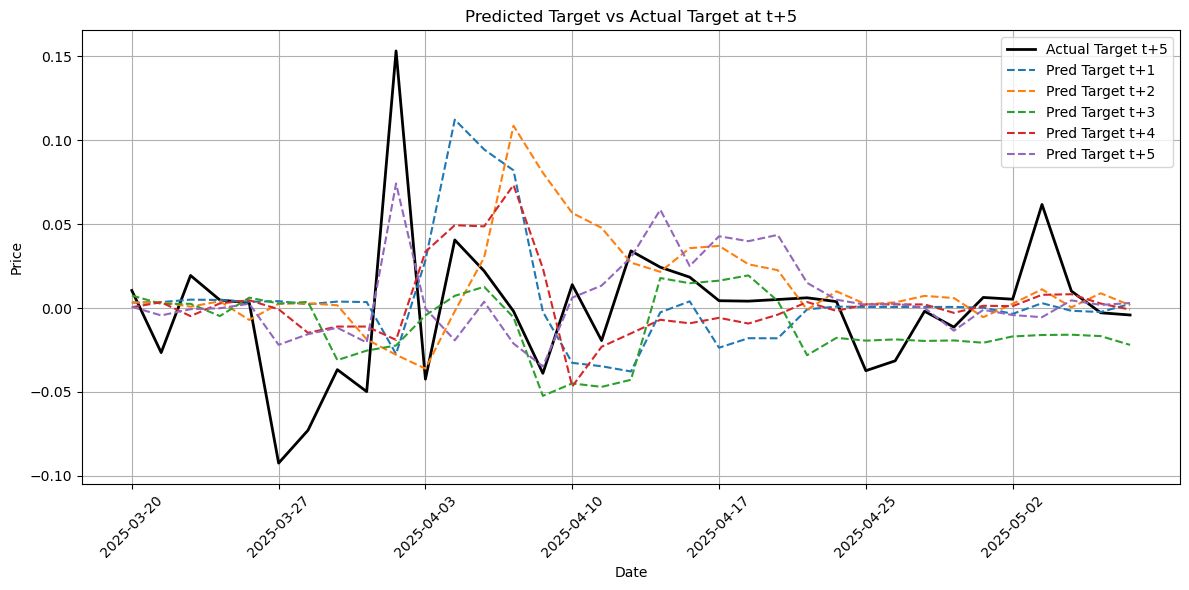

In [ ]:
plot_predictions_vs_actual(
    df=df.iloc[TEST_START_INDEX - 10:],
    actual_col='return_t+5',
    prediction_prefix='pred_return_t+',
    max_horizon=5
)

In [ ]:
def evaluate_strategy_with_cash(df, rebalance_every=3, buy_thresh=0.005, sell_thresh=-0.005, starting_cash=10000):
    """
    Evaluate a rebalanced strategy accounting for cash from sales.
    """
    df = df.copy().reset_index(drop=True)
    
    # Generate trading signals
    signals = []
    last_signal = 0  # initial position: hold
    for i in range(len(df)):
        if i % rebalance_every == 0:
            cum_return = df.loc[i, "cumulative_prediction"]
            if cum_return > buy_thresh:
                last_signal = 1  # Buy
            elif cum_return < sell_thresh:
                last_signal = 0  # Sell (move to cash)
            # else retain last_signal
        signals.append(last_signal)
    df["signal"] = signals

    # Track portfolio value over time
    portfolio_value = [starting_cash]
    invested = False
    units = 0

    for i in range(1, len(df)):
        signal = df.loc[i, "signal"]
        prev_value = portfolio_value[-1]
        actual_return = df.loc[i, "cumulative_actual"]

        if signal == 1:
            # Stay invested or enter the market
            if not invested:
                units = prev_value  # value in dollars invested
                invested = True
            new_value = units * (1 + actual_return)
        else:
            # Stay in cash
            new_value = prev_value
            invested = False
            units = 0

        portfolio_value.append(new_value)

    df["strategy_portfolio"] = portfolio_value

    # === Sequential market value computation ===
    market_values = [starting_cash]
    for i in range(1, len(df)):
        prev_value = market_values[-1]
        actual_return = df.loc[i, "return"]
        new_value = prev_value * (1 + actual_return)
        market_values.append(new_value)
    df["market_value"] = market_values

    # Final results
    final_strategy_value = df["strategy_portfolio"].iloc[-1]
    final_market_value = df["market_value"].iloc[-1]

    print(f"📊 Final Portfolio Values (Starting with ${starting_cash:,.0f}):")
    print(f"→ Strategy: ${final_strategy_value:,.2f}")
    print(f"→ Market Hold: ${final_market_value:,.2f}")

    # Plot
    plt.figure(figsize=(12, 6))
    plt.plot(df["date"], df["market_value"], label="Market (Buy & Hold)", color='blue')
    plt.plot(df["date"], df["strategy_portfolio"], label="Model Strategy", color='orange')
    plt.axhline(starting_cash, color='gray', linestyle='--', linewidth=0.8)
    plt.title("Portfolio Value Over Time")
    plt.xlabel("Date")
    plt.ylabel("Value ($)")
    plt.xticks(ticks=df["date"].iloc[::5], rotation=45)
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

    return df[["date", "cumulative_prediction", "return", "strategy_portfolio", "market_value"]]



📊 Final Portfolio Values (Starting with $10,000):
→ Strategy: $11,085.11
→ Market Hold: $9,719.47


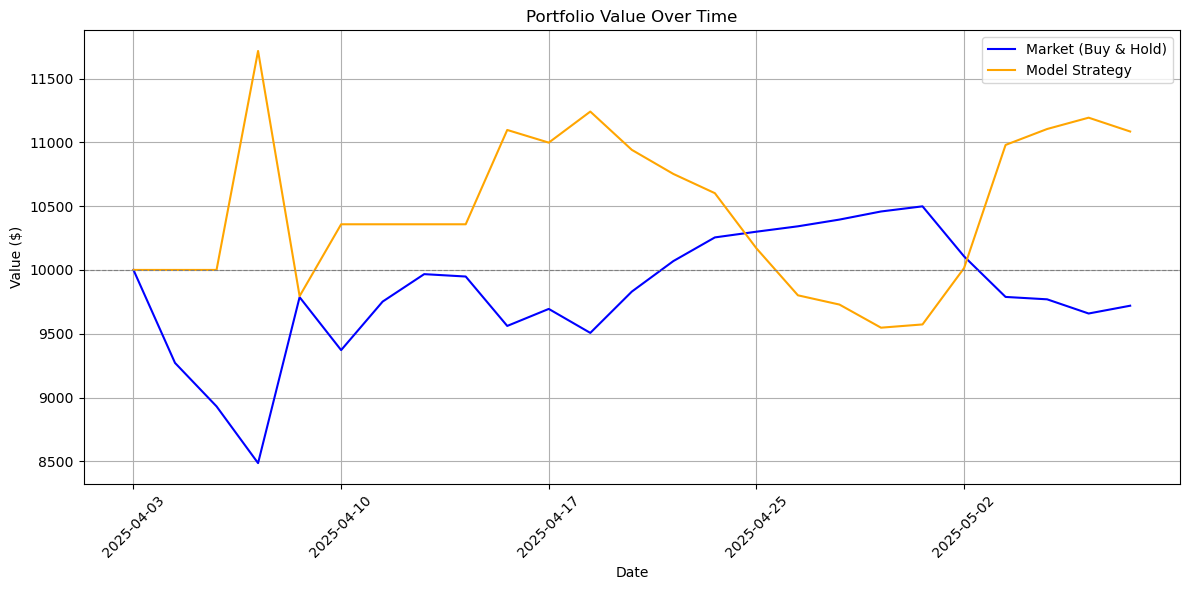

,date,cumulative_prediction,return,strategy_portfolio,market_value
0,2025-04-03,0.021235,-0.092456,10000.000000,10000.000000
1,2025-04-04,0.147873,-0.072887,10000.000000,9271.125676
2,2025-04-07,0.189764,-0.036734,10000.000000,8930.557829
3,2025-04-08,0.237383,-0.049818,11716.668504,8485.653629
4,2025-04-09,0.014983,0.153289,9794.449327,9786.406994
5,2025-04-10,-0.061529,-0.042394,10357.883489,9371.523986
6,2025-04-11,-0.043565,0.040594,10357.883489,9751.955880
7,2025-04-14,-0.038446,0.022054,10357.883489,9967.026027
8,2025-04-15,0.088537,-0.001876,10357.883489,9948.324079
9,2025-04-16,0.070471,-0.038933,11097.225389,9561.002113


In [ ]:
evaluate_strategy_with_cash(
    df.query("split == 'V'"), 
    rebalance_every=3, 
    buy_thresh=0.03, 
    sell_thresh=-0.03, 
    starting_cash=10000
    )


In [ ]:
pred_columns = [f"{pred_prefix}{h}" for h in range(1, 6)]
weights = [0.40, 0.30, 0.15, 0.10, 0.05]
df["weighted_prediction"] = df[pred_columns].dot(weights)

actual_columns = [f"{ACTUAL_PREFIX}_t+{h}" for h in range(1, 6)]
df["weighted_actual"] = df[actual_columns].mean(axis=1)

In [ ]:
df["split"] = np.where(df.index < TEST_START_INDEX, "T", "V")

In [ ]:
# generate_and_save_tabulations(
#     df,
#     "weighted_prediction",
#     "weighted_actual",
#     ["close", "volume", "finbert_0", 'sent_pos', 'sent_neu', 'sent_neg'],
#     "split"
    
# )